Chart hospitalizations from COVID-19 in Ottawa.

Richard Akerman

December 31, 2021

Code developed in Google Colaboratory will be posted to GitHub (scilib) with MIT License.

Code uses examples and techniques from:

*   Data to Fish - [How to Select Rows from Pandas DataFrame](https://datatofish.com/select-rows-pandas-dataframe/)
*   [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)
*   Stack Overflow - Python - [Get list from pandas dataframe column or row?](https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row)
*   tutorialspoint - [Matplotlib - Bar Plot](https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm)
*   Geeks for Geeks - [Plotting multiple bar charts using Matplotlib in Python](https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/)
*Geeks for Geeks - [Matplotlib.pyplot.colors() in Python](https://www.geeksforgeeks.org/matplotlib-pyplot-colors-in-python/)
*   Google - [Charting in Colaboratory](https://colab.research.google.com/notebooks/charts.ipynb)
*   towards data science (subscription) - [Pretty displaying tricks for columnar data in Python](https://towardsdatascience.com/pretty-displaying-tricks-for-columnar-data-in-python-2fe3b3ed9b83)
*  DelftStack - [Hide Axis Text Ticks and/or Tick Labels in Matplotlib](https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/)

Data from Ontario open data - [COVID-19 cases in hospital and ICU, by Ontario Health (OH) region](https://data.ontario.ca/en/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)

This is rows labeled by region, EAST is the one this code uses.

Verified that East is the correct region for Ottawa, see e.g. [Ontario Public Health Units and Health Unit Regions](https://www.researchgate.net/figure/Ontario-public-health-units-and-health-unit-regions_fig1_322667994)

Note that what is plotted for ICU is cases that are currently testing positive for COVID-19, not total cases, due to some historical issues with the dataset.

TODO: Label chart with dates

Caveats: Will break if data URL changes or if data format changes.

September 28, 2023

It looks like data.ontario.ca is now checking the user agent in the header, and does not like seeing the default Python-urllib that Colab is probably sending.

Have to change the code to send a fake web browser user agent and accompanying Accept text.

Basic concept from

[Set User Agent On Pandas Read_Csv](https://waylonwalker.com/pandas-read-csv-user-agent/) by Waylon Walker from Learning in Public @_WaylonWalker

Specific URL request header from

StackOverflow - [urllib2.HTTPError: HTTP Error 403: Forbidden](https://stackoverflow.com/questions/13303449/urllib2-httperror-http-error-403-forbidden)

As the table now has missing values (NaN = Not a Number), I added code for the table to replace nan with a "-".

StackOverflow - [Properly handling missing values and formatting for pandas data frame printed to tabulate](https://stackoverflow.com/questions/71165558/properly-handling-missing-values-and-formatting-for-pandas-data-frame-printed-to)

November 24, 2023

Debugging indicates that ICU and ventilator numbers are now coming in as text for some reason.

Python can plot text "values", but the behaviour is unexpected and hard to diagnose.  It will plot with the y-axis minimum as the smallest text value.  It *will not* let you set a y-axis minimum of zero (it doesn't matter if you use the correct syntax for y-axis minimum, it simply gets ignored, because it's not a numeric plot).  You have to convert the text strings to numbers and then plotting will work as expected again.

Stack Overflow - [How to convert string to number in python?](https://stackoverflow.com/questions/74665788/how-to-convert-string-to-number-in-python)

Line number, Date,
Hos = Hospitalizations
IC = ICU current COVID-19
IV = ICU current COVID-19 on ventilator
- means Not a Number (a blank entry)


line  YYYY-MM-DD  Hos  IC  IV
----  ----------  ---  --  -
2628  2023-10-21  248  11  2
2629  2023-10-22  287  14  1
2630  2023-10-23  295  12  2
2631  2023-10-24  302  13  4
2632  2023-10-25  282  14  3
2633  2023-10-26  284  15  1
2634  2023-10-27  258  15  3
2635  2023-10-28  251  15  2
2636  2023-10-29  265  16  4
2637  2023-10-30  266  13  4
2638  2023-10-31  259  13  2
2639  2023-11-01  252  14  4
2640  2023-11-02  259  15  5
2641  2023-11-03  276  16  3
2642  2023-11-04  260  19  4
2643  2023-11-05  300  19  4
2644  2023-11-06  287  17  1
2645  2023-11-07  311  19  1
2646  2023-11-08  333  22  1
2647  2023-11-09  323  21  2
2648  2023-11-10  316  17  1
2649  2023-11-11  339  17  3
2650  2023-11-12  349  21  5
2651  2023-11-13  368  21  4
2652  2023-11-14  337  21  5
2653  2023-11-15  370  23  4
2654  2023-11-16  350  23  4
2655  2023-

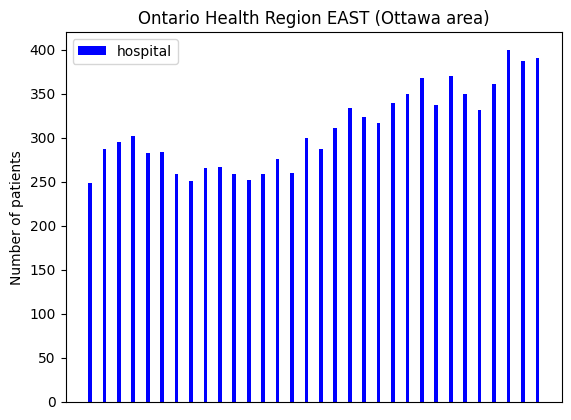

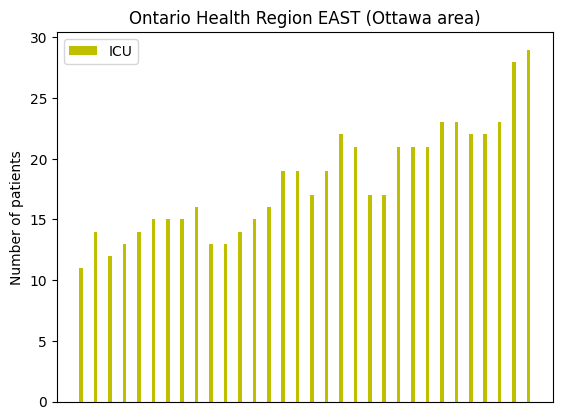

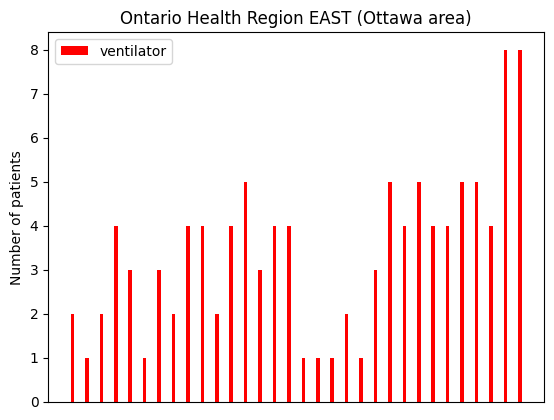

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tabulate import tabulate
from ast import literal_eval

hospitalizations_url = "https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv"
# hospitalizations_data = pd.read_csv(hospitalizations_url)
url_request_header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
hospitalizations_data = pd.read_csv( hospitalizations_url , storage_options = url_request_header )

# 2023-11-24 ICU and ventilator numbers are now coming in as strings, which was breaking the plots

# extract most recent number_of_items days of hospitalizations
# Ottawa is Ontario Health region EAST

desired_row = "EAST"
hospital_column = "hospitalizations"
hospital_label = 'hospital'
icu_column = "icu_current_covid"
icu_label = 'ICU'
ventilator_column = 'icu_current_covid_vented'
ventilator_label = 'ventilator'
number_of_items = 32
offset_width = 0.25

# extract only the rows matching desired_row (EAST)
selected_hospital_rows = hospitalizations_data.loc[hospitalizations_data['oh_region'] == desired_row]

# make a table
# using tabulate because otherwise it is wrapping the rows for some reason
print("Line number, Date,")
print("Hos = Hospitalizations")
print("IC = ICU current COVID-19")
print("IV = ICU current COVID-19 on ventilator")
print("- means Not a Number (a blank entry)")
print("\n")
print("line  YYYY-MM-DD  Hos  IC  IV")
print(tabulate(selected_hospital_rows[['date', hospital_column, icu_column, ventilator_column]].tail(number_of_items).replace(np.nan, None), missingval='-'))
print("\n")

# make three charts
r = np.arange(number_of_items) # just a set of index values for the plot

# print hospitalizations (for debugging)
# print( list(selected_hospital_rows[hospital_column].tail(number_of_items)) )

# 1 plot hospitalizations
plt.bar( r , list(selected_hospital_rows[hospital_column].tail(number_of_items)), color ='b' , label = hospital_label, width = offset_width)

plt.plot()

plt.ylabel("Number of patients")
plt.title("Ontario Health Region EAST (Ottawa area)")
plt.legend(loc="upper left")

# hide meaningless x-axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.show()

#clear plot and axes
plt.clf()
plt.close()

# ----

# print ICU (for debugging)
# print( list(selected_hospital_rows[icu_column].tail(number_of_items)) )

# 2 plot ICU

# have to convert list of strings to list of numbers
icu_numbers = list( map(literal_eval, list(selected_hospital_rows[icu_column].tail(number_of_items))) )

plt.bar( r , icu_numbers, color ='y', label = icu_label, width = offset_width)

plt.plot()

plt.ylabel("Number of patients")
plt.title("Ontario Health Region EAST (Ottawa area)")
plt.legend(loc="upper left")

# hide meaningless x-axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.show()

#clear plot and axes
plt.clf()
ax.cla()

# ----

# print ventilator (for debugging)
# print( list(selected_hospital_rows[ventilator_column].tail(number_of_items)) )

# plot ventilator

# have to convert list of strings to list of numbers
ventilator_numbers = list( map(literal_eval, list(selected_hospital_rows[ventilator_column].tail(number_of_items))) )

plt.bar( r , ventilator_numbers, color ='r', label = ventilator_label, width = offset_width)

plt.plot()

plt.ylabel("Number of patients")
plt.title("Ontario Health Region EAST (Ottawa area)")
plt.legend(loc="upper left")

# hide meaningless x-axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.show()